## 데이터 분석

Train samples: 3696
Test samples: 462
Classes: ['class1', 'class2', 'class3']


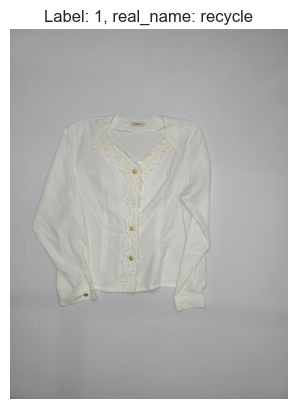

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1데이터 로드
data_dir = "data/dress"  # 상위 폴더
class_names = ['dispose', 'recycle', 'reusable']

transform = transforms.Compose([
    transforms.ToTensor()
])

tr = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
te = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

print(f"Train samples: {len(tr)}")
print(f"Test samples: {len(te)}")
print(f"Classes: {tr.classes}")

# 2️예시 이미지 출력
img, label = tr[1100]
real_label = class_names[label]

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}, real_name: {real_label}")
plt.axis("off")
plt.show()


In [2]:
import os, cv2, time
data_dir = "data/dress/train"
files = [os.path.join(root, f) for root, _, fs in os.walk(data_dir) for f in fs if f.endswith(".jpg")]
print("총 이미지:", len(files))
t0 = time.perf_counter()
for i, p in enumerate(files[:10]):
    img = cv2.imread(p)
    if img is None: print("로드 실패:", p)
print("10장 처리 시간:", time.perf_counter()-t0, "초")


총 이미지: 3696
10장 처리 시간: 0.48423089999414515 초


In [9]:
import os, pandas as pd
from PIL import Image
from tqdm import tqdm

data_dir = "data/dress/train"
paths, labels, widths, heights = [], [], [], []

for label in os.listdir(data_dir):
    folder = os.path.join(data_dir, label)
    for file in tqdm(os.listdir(folder), desc=f"{label:15s}"):
        path = os.path.join(folder, file)
        try:
            with Image.open(path) as img:
                w, h = img.size
                paths.append(path)
                labels.append(label)
                widths.append(w)
                heights.append(h)
        except:
            continue

df = pd.DataFrame({"path": paths, "label": labels, "width": widths, "height": heights})
print(df.groupby("label").agg({"path": "count", "width": "mean", "height": "mean"}))


class3         : 100%|██████████| 2074/2074 [00:03<00:00, 556.86it/s]

        path   width  height
label                       
class1   438  3000.0  4000.0
class2  1184  3000.0  4000.0
class3  2074  3000.0  4000.0


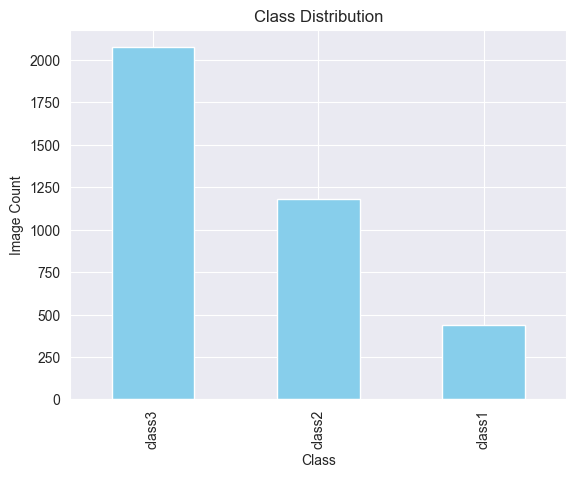

In [10]:
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.show()


In [11]:
import numpy as np, cv2
brightness, contrast, blur = [], [], []
sample = df.sample(50, random_state=0)['path']

for p in sample:
    img = np.array(Image.open(p).convert('L'))
    brightness.append(np.mean(img))
    contrast.append(np.std(img))
    blur.append(cv2.LaplaciaSn(img, cv2.CV_64F).var())

print(f"Brightness mean={np.mean(brightness):.2f}, Contrast={np.mean(contrast):.2f}, Blur={np.mean(blur):.2f}")


Brightness mean=169.16, Contrast=32.79, Blur=102.28


In [16]:
import numpy as np
import pandas as pd
from PIL import Image

# --- 클래스별로 순회하며 밝기 통계 계산 ---
stats = []

for label in df['label'].unique():
    paths = df[df['label'] == label]['path'].sample(
        min(200, len(df[df['label'] == label])),  # 클래스별 최대 200장만 샘플링
        random_state=42
    )

    brightness_vals = []
    for p in paths:
        try:
            img = Image.open(p).convert('L')  # 흑백 변환
            arr = np.array(img, dtype=np.float32)
            brightness_vals.append(np.mean(arr))
        except:
            continue

    # pandas로 요약 통계 구하기
    s = pd.Series(brightness_vals)
    stats.append({
        "label": label,
        "count": len(brightness_vals),
        "min": np.round(s.min(), 2),
        "max": np.round(s.max(), 2),
        "mean": np.round(s.mean(), 2),
        "median": np.round(s.median(), 2),
        "std": np.round(s.std(), 2)
    })

# --- 결과 요약 테이블 ---
brightness_df = pd.DataFrame(stats).set_index("label")
display(brightness_df)


,count,min,max,mean,median,std
label,,,,,,
class1,200,135.270004,183.470001,171.649994,173.000000,7.65
class2,200,143.699997,185.679993,169.160004,170.350006,7.92
class3,200,143.000000,185.440002,168.820007,170.600006,9.38


📦 총 이미지 수: 3696


width                   height                  brightness        ...  \
         mean  std   min   max    mean  std   min   max       mean   std  ...   
label                                                                     ...   
dress  3000.0  0.0  3000  3000  4000.0  0.0  4000  4000     170.96  8.91  ...   

           r_mean                  g_mean                                 \
              min         max        mean    std         min         max   
label                                                                      
dress  135.830002  199.229996  165.449997  11.48  127.209999  198.839996   

           b_mean                                 
             mean    std         min         max  
label                                             
dress  164.419998  11.94  136.009995  195.570007  

[1 rows x 28 columns]

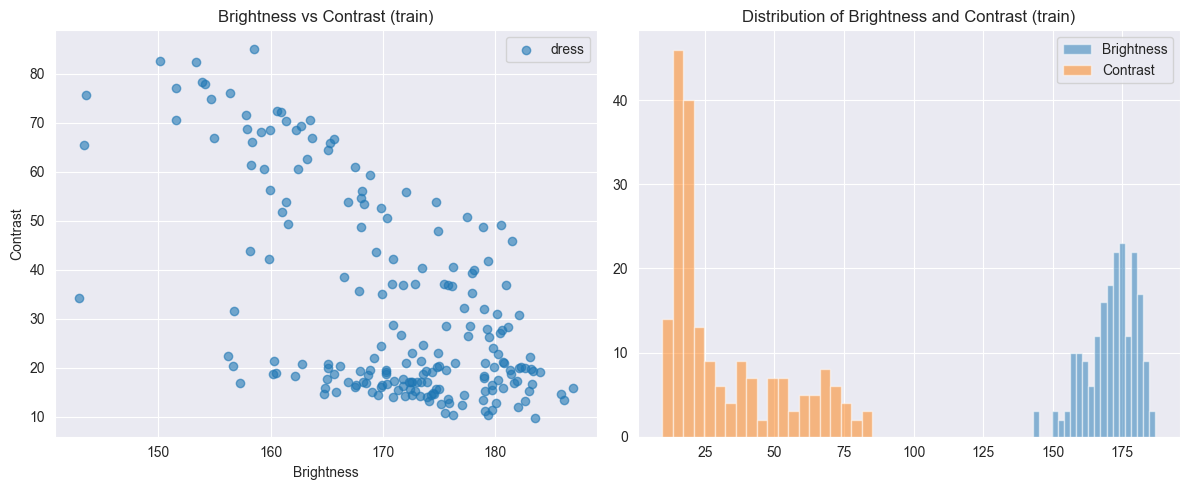

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# === 1. train 경로 설정 ===
train_dir = "data/dress/train"

# === 2. train 내부 모든 이미지 경로 수집 ===
paths = []
labels = []
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(label_path, file))
                labels.append(label)

df = pd.DataFrame({"path": paths, "label": labels})
print(f"📦 총 이미지 수: {len(df)}")

# === 3. 샘플링 (최대 200장) ===
sample_df = df.sample(min(200, len(df)), random_state=42).copy()

# === 4. 이미지 분석 함수 ===
def analyze_image(path):
    try:
        img = Image.open(path).convert('RGB')
        arr = np.array(img, dtype=np.float32)

        # RGB 평균
        r_mean, g_mean, b_mean = arr.mean(axis=(0,1))

        # 대비 & 밝기
        contrast = arr.std()
        brightness = np.mean(ImageOps.grayscale(img))

        # 해상도
        width, height = img.size

        return {
            "label": path.split('/')[-2],
            "path": path,
            "width": width,
            "height": height,
            "brightness": round(brightness, 2),
            "contrast": round(contrast, 2),
            "r_mean": round(r_mean, 2),
            "g_mean": round(g_mean, 2),
            "b_mean": round(b_mean, 2)
        }
    except:
        return None

# === 5. EDA 수행 ===
results = [analyze_image(p) for p in sample_df["path"]]
eda_df = pd.DataFrame([r for r in results if r is not None])

# === 6. 클래스별 통계 요약 ===
summary = (
    eda_df.groupby("label")[["width","height","brightness","contrast","r_mean","g_mean","b_mean"]]
    .agg(["mean","std","min","max"])
    .round(2)
)
display(summary)

# === 7. 시각화 ===
plt.figure(figsize=(12,5))

# (1) 밝기 vs 대비 산점도
plt.subplot(1,2,1)
for label in eda_df["label"].unique():
    subset = eda_df[eda_df["label"] == label]
    plt.scatter(subset["brightness"], subset["contrast"], alpha=0.6, label=label)
plt.xlabel("Brightness"); plt.ylabel("Contrast")
plt.title("Brightness vs Contrast (train)")
plt.legend()

# (2) 밝기 / 대비 히스토그램
plt.subplot(1,2,2)
plt.hist(eda_df["brightness"], bins=20, alpha=0.5, label="Brightness")
plt.hist(eda_df["contrast"], bins=20, alpha=0.5, label="Contrast")
plt.title("Distribution of Brightness and Contrast (train)")
plt.legend()

plt.tight_layout()
plt.show()
